In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
c = 2.99792458e8   # m/s

In [130]:
def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return np.sqrt(frac)
        
def state(xs, xps, yps):
    # returns a, b such that ys = a * xs + b
    yps = np.concatenate((yps, [yps[-1]]), axis=0) # hack for end of grid
    xps = np.concatenate((xps, [xps[-1]+1.]), axis=0) # hack for end of grid
    mps = np.searchsorted(xps, xs, side='left')
    yps = np.concatenate(([yps[0]], yps), axis=0) # hack for end of grid
    xps = np.concatenate(([xps[0]-1.], xps), axis=0) # hack for end of grid
    ehs = (yps[mps+1] - yps[mps])/(xps[mps+1] - xps[mps])
    bes = yps[mps] - ehs * xps[mps]
    return ehs, bes
    
def P(ehs, bes, xs):
    return ehs * xs + bes
    
def dPdx(ehs):
    return ehs # lol
    
def Pdot(lnlambdas, lnlambdaps, lnfluxps, v):
    if v.ndim == 0:
        N = 1
    else:
        N = len(v)
    M = len(lnlambdas)
    lnlambdas_shifted = np.tile(lnlambdas, (N,1)) + np.tile(np.log(doppler(v)), (M,1)).T # N x M
    ehs, bes = state(lnlambdas_shifted, lnlambdaps, lnfluxps)
    return P(ehs, bes, lnlambdas_shifted) # this is lnfluxs

In [308]:
def oned_gaussian(xs, mm, sig):
    return np.exp(-0.5 * (xs - mm) ** 2 / sig ** 2) / np.sqrt(2. * np.pi * sig)

def make_synth(rv, xs, ds, ms, sigs):
    """
    `rv`: radial velocity in m/s (or same units as `c` above
    `xs`: `[M]` array of wavelength values
    `ds`: depths at line centers
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    synths = np.ones_like(xs)
    for d, m, sig in zip(ds, ms, sigs):
        synths *= np.exp(d *
            oned_gaussian(xs * doppler(rv), m, sig))
    return synths

def make_data(N, xs, ds, ms, sigs):
    """
    `N`: number of spectra to make
    `xs`: `[M]` array of wavelength values
    `ds`: depth-like parameters for lines
    `ms`: locations of the line centers in rest wavelength
    `sigs`: Gaussian sigmas of lines
    """
    M = len(xs)
    data = np.zeros((N, M))
    ivars = np.zeros((N, M))
    rvs = 30000. * np.random.uniform(-1., 1., size=N) # 30 km/s bc Earth ; MAGIC
    for n, rv in enumerate(rvs):
        ivars[n, :] = 10000. # s/n = 100 ; MAGIC
        data[n, :] = make_synth(rv, xs, ds, ms, sigs)
        data[n, :] += np.random.normal(size=M) / np.sqrt(ivars[n, :])
    return data, ivars, rvs

In [309]:
fwhms = [0.1077, 0.1113, 0.1044, 0.1083, 0.1364, 0.1, 0.1281,
                    0.1212, 0.1292, 0.1526, 0.1575, 0.1879] # FWHM of Gaussian fit to line (A)
sigs = np.asarray(fwhms) / 2. / np.sqrt(2. * np.log(2.)) # Gaussian sigma (A)
ms = [4997.967, 4998.228, 4998.543, 4999.116, 4999.508, 5000.206, 5000.348,
                5000.734, 5000.991, 5001.229, 5001.483, 5001.87] # line center (A)
ds = [-0.113524, -0.533461, -0.030569, -0.351709, -0.792123, -0.234712, -0.610711,
                -0.123613, -0.421898, -0.072386, -0.147218, -0.757536] # depth of line center (normalized flux)
ws = np.ones_like(ds) # dimensionless weights
dx = 0.01 # A
xs = np.arange(4998. + 0.5 * dx, 5002., dx) # A
        
N = 16
data, ivars, true_rvs = make_data(N, xs, ds, ms, sigs)

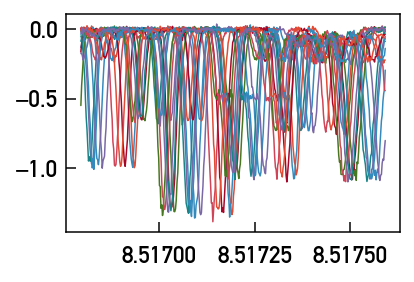

In [310]:
data = np.log(data)
data_xs = np.log(xs)
for i in range(N):
    plt.plot(data_xs, data[i])

In [311]:
model_xs = np.arange(4996., 5004., dx)
model_ys = np.log(make_synth(0.0, model_xs, ds, ms, sigs))
model_xs = np.log(model_xs)

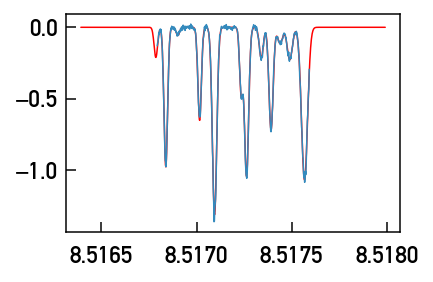

In [312]:
plt.plot(model_xs, model_ys, color='red')
plt.plot(data_xs + np.log(doppler(true_rvs[0])), data[0,:])

In [313]:
test_rvs = np.arange(23000, 24000, 10.)
chisq = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    pd = Pdot(data_xs, model_xs, model_ys, v)
    chisq[i] = np.sum((data[0,:] - pd)**2 * ivars[0,:])

(23300, 23500)

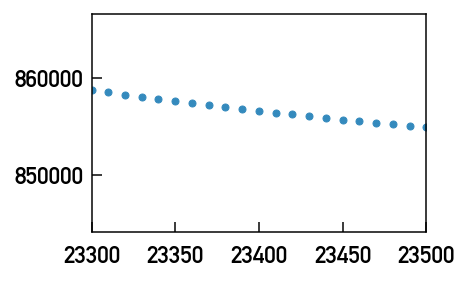

In [298]:
plt.scatter(test_rvs, chisq)
plt.axvline(true_rvs[0])
plt.xlim([23300,23500])
#plt.ylim([7000,7500])

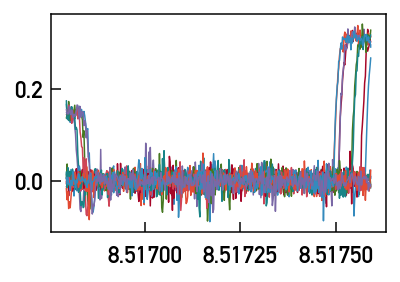

In [103]:
pd = Pdot(data_xs, model_xs, model_ys, true_rvs)
for i in range(N):
    plt.plot(data_xs, data[i,:] - pd[i])

In [137]:
def chisq(rvs, data_xs, data, ivars, model_xs, model_ys):
    pd = Pdot(data_xs, model_xs, model_ys, rvs)
    return np.sum((data - pd)**2 * ivars)

(7000, 7500)

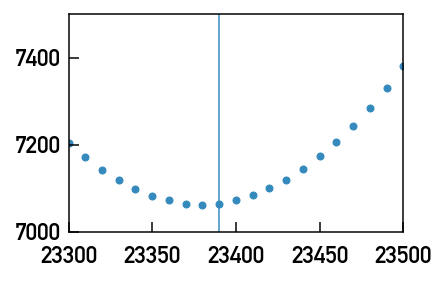

In [138]:
test_rvs = np.arange(23000, 24000, 10.)
chisqs = np.zeros_like(test_rvs)
for i,v in enumerate(test_rvs):
    chisqs[i] = chisq(v, data_xs, data[0,:], ivars[0,:], model_xs, model_ys)
    
    
plt.scatter(test_rvs, chisqs)
plt.axvline(true_rvs[0])
plt.xlim([23300,23500])
plt.ylim([7000,7500])

In [139]:
from scipy.optimize import fmin_cg

In [167]:
x0 = true_rvs + np.random.normal(0., 100., N)

soln =  fmin_cg(chisq, x0[0], args=(data_xs, data[0,:], ivars[0,:], model_xs, model_ys), gtol=1.e-8, epsilon=1.5e-5)

#print chisq(x0, data_xs, data, ivars, model_xs, model_ys)
#print chisq(true_rvs, data_xs, data, ivars, model_xs, model_ys)

         Current function value: 7061.695966
         Iterations: 3
         Function evaluations: 50
         Gradient evaluations: 13


In [168]:
soln[0] - true_rvs[0]

-8.5020064282944077

In [169]:
soln =  fmin_cg(chisq, x0, args=(data_xs, data, ivars, model_xs, model_ys), gtol=1.e-8, epsilon=1.5e-5)


         Current function value: 246251.799262
         Iterations: 20
         Function evaluations: 1903
         Gradient evaluations: 105


In [174]:
print soln - true_rvs

print soln - x0

[ -8.52672519  -6.66453852  20.86006268   1.42493072  19.24252099
   4.99175725 -14.64027675   8.36099241 -14.3974177   -2.84252951
  14.57528289   8.6446289  -25.88594712  -3.84949804  14.10417299
  -7.44940606]
[  80.93245727   68.10074895  -17.0921816    31.1344012   168.10438758
 -108.45615348  -80.20041009   99.63497773 -119.50775307   38.1175771
 -180.38966709   -1.82124756  -86.33690662  109.63264697 -188.69519724
  -81.3739364 ]


In [178]:
np.std(soln - true_rvs)

12.921972715774894

Let's add a tellurics model component!

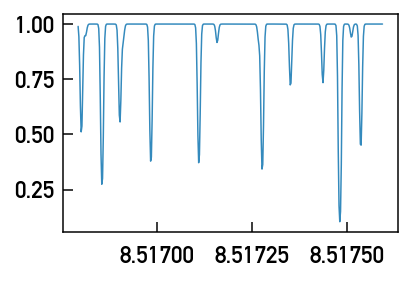

In [325]:
def add_tellurics(xs, all_data, true_rvs, lambdas, strengths, dx):
    N, M = np.shape(all_data)
    tellurics = np.ones_like(xs)
    for ll, s in zip(lambdas, strengths):
        tellurics *= np.exp(-s * oned_gaussian(xs, ll, dx))
    plt.plot(xs, tellurics)
    all_data *= np.repeat([tellurics,],N,axis=0)
    return all_data

n_tellurics = 16 # magic
telluric_sig = 3.e-6 # magic
telluric_xs = np.random.uniform(data_xs[0], data_xs[-1], n_tellurics)
strengths = 0.01 * np.random.uniform(size = n_tellurics) ** 2. # magic numbers
all_data = np.exp(data)
all_data = add_tellurics(data_xs, all_data, true_rvs, telluric_xs, strengths, telluric_sig)
data = np.log(all_data)


In [326]:
model_xs_star = data_xs
model_ys_star = np.log(make_synth(0.0, xs, ds, ms, sigs))
model_xs_t = data_xs
tellurics_model = np.ones_like(data_xs)
for ll, s in zip(telluric_xs, strengths):
    tellurics_model *= np.exp(-s * oned_gaussian(data_xs, ll, telluric_sig))
model_ys_t = np.log(tellurics_model)

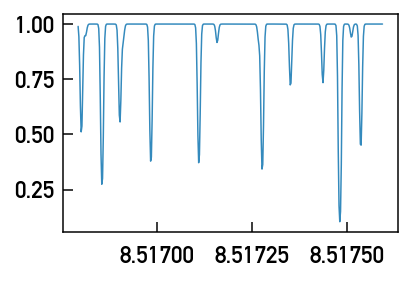

In [327]:
plt.plot(model_xs_t, tellurics_model)

array([[ 0.85862535,  0.83343513,  0.72283303, ...,  0.62735692,
         0.64754151,  0.74361141],
       [ 0.97093984,  0.91202214,  0.77933719, ...,  0.92053891,
         0.925223  ,  0.94754328],
       [ 0.82950746,  0.84353055,  0.7625696 , ...,  0.98546288,
         0.9889024 ,  0.99283198],
       ..., 
       [ 0.96897637,  0.92268378,  0.81076492, ...,  0.94943851,
         0.91220087,  0.91576359],
       [ 0.94308191,  0.90893566,  0.79433089, ...,  0.88719945,
         0.92406127,  0.93362674],
       [ 0.95229072,  0.92457424,  0.7755908 , ...,  0.98041344,
         1.00269961,  0.99227732]])

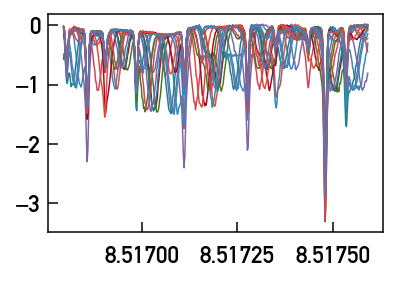

In [328]:
for i in range(N):
    plt.plot(data_xs, data[i,:])
all_data

In [318]:
def chisq_star(rvs_star, rvs_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

def chisq_t(rvs_t, rvs_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t):
    pd_star = Pdot(data_xs, model_xs_star, model_ys_star, rvs_star)
    pd_t = Pdot(data_xs, model_xs_t, model_ys_t, rvs_t)
    pd = pd_star + pd_t
    return np.sum((data - pd)**2 * ivars)

x0_star = true_rvs + np.random.normal(0., 100., N)
x0_t = np.zeros(N)
soln_star =  fmin_cg(chisq_star, x0_star, args=(x0_t, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)
soln_t =  fmin_cg(chisq_t, x0_t, args=(soln_star, data_xs, data, ivars, model_xs_star, model_ys_star, model_xs_t, model_ys_t),
                     gtol=1.e-8, epsilon=1.5e-5)


         Current function value: 226872.863313
         Iterations: 14
         Function evaluations: 1290
         Gradient evaluations: 71
         Current function value: 222859.553598
         Iterations: 362
         Function evaluations: 53202
         Gradient evaluations: 2955


In [319]:
print soln_star - true_rvs

print soln_star - x0_star

print np.std(soln_star - true_rvs)

[  2.25997707 -15.00947671 -21.63955617  11.96164935  18.47563869
  32.20082299  23.44820712   9.39929586  -0.87151722   4.19499244
  -2.99134891   8.19943203   3.79006263  -3.36880713  25.3146064
  14.13035062]
[-131.75919141 -105.57038786 -116.84734209   52.80940083 -227.22865227
  200.80877904  204.36323508   56.61041616  -52.56987938  146.8493122
   32.00069352   84.54144406   88.38275965   25.3417071    -9.41577549
  -11.05232647]
13.8509558188


In [320]:
print soln_t
print np.std(soln_t)

[  414.45832336  -120.94541879 -2388.48166183 -2019.97785561   715.9486169
  -501.89683236  5998.3764645   5016.63091664  -564.36678335  3051.36466562
 -2739.8277264  -2755.17074371 -2075.55685354  2399.40795613  -187.5962005
 -2175.03655946]
2635.97776846


In [321]:
pd_star = Pdot(data_xs, model_xs_star, model_ys_star, soln_star)
pd_t = Pdot(data_xs, model_xs_t, model_ys_t, soln_t)
pd = pd_star + pd_t

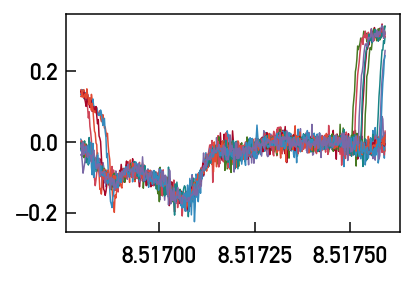

In [322]:
for i in range(N):
    plt.plot(data_xs, data[i,:] - pd_star[i,:])

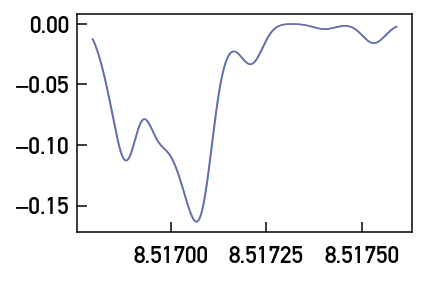

In [323]:
plt.plot(data_xs, pd_t[0,:])
plt.plot(data_xs, model_ys_t)

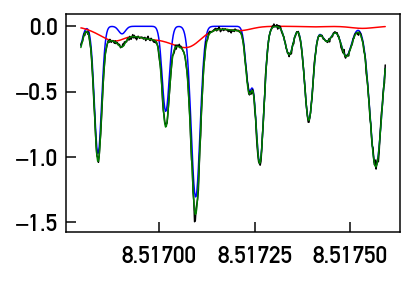

In [324]:
plt.plot(data_xs, pd_star[0,:], color='blue')
plt.plot(data_xs, pd_t[0,:], color='red')

plt.plot(data_xs, data[0,:], color='k')

plt.plot(data_xs, pd[0,:], color='green')